# Equations with first order term

In [1]:
!poetry --version > /dev/null 2> /dev/null || pip install poetry
!python -c 'import notebooks_lib' 2> /dev/null || pip install git+https://github.com/gbonnet1/notebooks.git

In [2]:
import agd.LinearParallel as lp
import matplotlib.pyplot as plt
import numpy as np
from agd import Domain, Selling
from agd.AutomaticDifferentiation import Dense2, Sparse

In [3]:
def u_c4(x):
    return np.where(
        lp.dot_VV(x, x) < 1,
        lp.dot_VV(x, x) ** (3 / 2),
        1 / 10
        - 1 / 2 * lp.dot_VV(x, x) ** (1 / 2)
        + lp.dot_VV(x, x) ** (2 / 2)
        + 1 / 2 * lp.dot_VV(x, x) ** (4 / 2)
        - 1 / 10 * lp.dot_VV(x, x) ** (5 / 2),
    )


def u_c3(x):
    return np.where(
        lp.dot_VV(x, x) < 1,
        lp.dot_VV(x, x) ** (3 / 2),
        1 / 6
        - 2 / 3 * lp.dot_VV(x, x) ** (1 / 2)
        + lp.dot_VV(x, x) ** (2 / 2)
        + 1 / 3 * lp.dot_VV(x, x) ** (3 / 2)
        + 1 / 6 * lp.dot_VV(x, x) ** (4 / 2),
    )


def u_c2(x):
    return np.where(
        lp.dot_VV(x, x) < 1,
        lp.dot_VV(x, x) ** (3 / 2),
        1 / 3
        - lp.dot_VV(x, x) ** (1 / 2)
        + lp.dot_VV(x, x) ** (2 / 2)
        + 2 / 3 * lp.dot_VV(x, x) ** (3 / 2),
    )


mu = 0.1
h_max = mu ** (3 / 2) / 2


def omega(x):
    return lp.dot_AV(
        lp.rotation(np.pi * x[0] / 2), np.multiply.outer([1, 0], np.ones(x.shape[1:]))
    )


def D(x):
    return lp.dot_AA(
        lp.rotation(np.pi * x[1] / 2),
        lp.dot_AA(
            np.multiply.outer([[1, 0], [0, mu]], np.ones(x.shape[1:])),
            lp.transpose(lp.rotation(np.pi * x[1] / 2)),
        ),
    )


def EqLinear(u_func, x):
    x_ad = Dense2.identity(constant=x, shape_free=x.shape[:1])
    u_ad = u_func(x_ad)
    u = u_ad.value
    du = np.moveaxis(u_ad.coef1, -1, 0)
    d2u = np.moveaxis(u_ad.coef2, [-2, -1], [0, 1])
    return u - lp.dot_VV(omega(x), du) - lp.trace(lp.dot_AA(D(x), d2u))


def SchemeLinear(u, x, f, bc):
    coef, offsets = Selling.Decomposition(D(x))
    du = bc.DiffCentered(u, offsets)
    d2u = bc.Diff2(u, offsets)
    return np.where(
        bc.interior,
        u
        - lp.dot_VV(
            coef,
            du
            * lp.dot_VAV(
                np.expand_dims(omega(x), 1),
                np.expand_dims(lp.inverse(D(x)), 2),
                offsets,
            )
            + d2u,
        )
        - f,
        u - bc.grid_values,
    )


def SolveLinear(x, f, bc):
    u = Sparse.identity(constant=np.zeros(x.shape[1:]))
    residue = SchemeLinear(u, x, f, bc)
    return residue.solve()

/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()


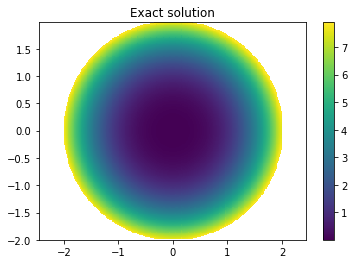

/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


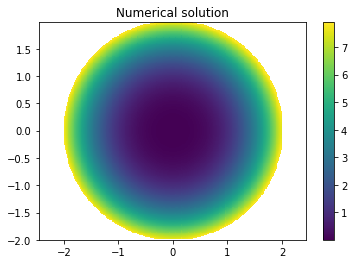

/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


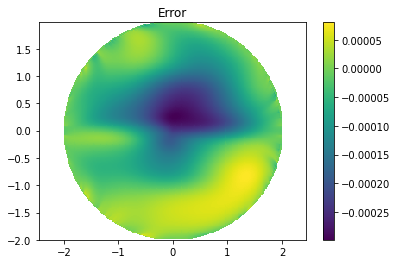

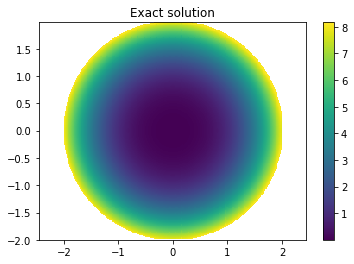

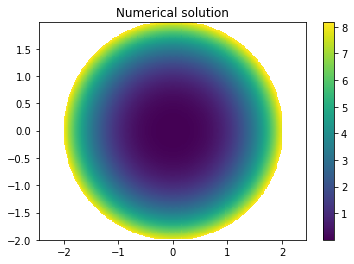

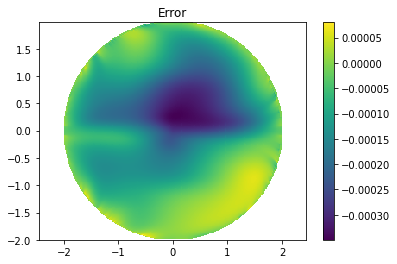

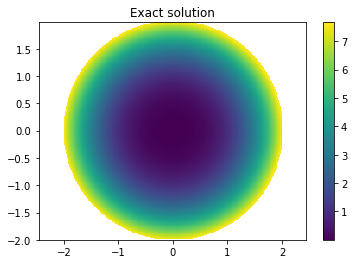

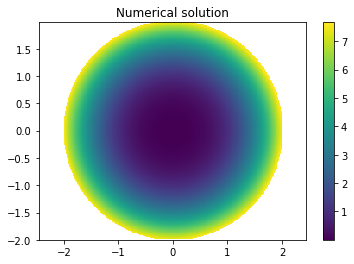

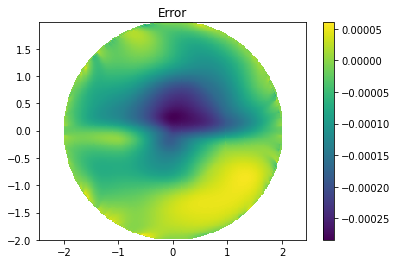

In [4]:
for u_func in [u_c4, u_c3, u_c2]:
    x = np.stack(
        np.meshgrid(np.arange(-2, 2, h_max), np.arange(-2, 2, h_max), indexing="ij")
    )

    domain = Domain.Ball(radius=2)
    bc = Domain.Dirichlet(domain, u_func, x)

    u = u_func(x)
    f = EqLinear(u_func, x)

    u_approx = SolveLinear(x, f, bc)

    plt.title("Exact solution")
    plt.axis("equal")
    im = plt.pcolormesh(*x, np.where(bc.interior, u, np.nan))
    plt.colorbar(im)
    plt.show()

    plt.title("Numerical solution")
    plt.axis("equal")
    im = plt.pcolormesh(*x, np.where(bc.interior, u_approx, np.nan))
    plt.colorbar(im)
    plt.show()

    plt.title("Error")
    plt.axis("equal")
    im = plt.pcolormesh(*x, np.where(bc.interior, u - u_approx, np.nan))
    plt.colorbar(im)
    plt.show()

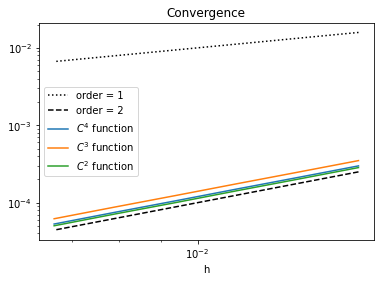

In [5]:
h = h_max / 2 ** np.arange(0, 1.5, 0.25)

plt.title("Convergence")
plt.xlabel("h")
plt.loglog(h, h, "k:", label="order = 1")
plt.loglog(h, h ** 2, "k--", label="order = 2")

for u_func, label in [
    (u_c4, "$C^4$ function"),
    (u_c3, "$C^3$ function"),
    (u_c2, "$C^2$ function"),
]:
    err = np.zeros(h.shape)

    for i in range(len(h)):
        x = np.stack(
            np.meshgrid(np.arange(-2, 2, h[i]), np.arange(-2, 2, h[i]), indexing="ij")
        )

        domain = Domain.Ball(radius=2)
        bc = Domain.Dirichlet(domain, u_func, x)

        u = u_func(x)
        f = EqLinear(u_func, x)

        u_approx = SolveLinear(x, f, bc)

        err[i] = np.max(np.abs(np.where(bc.interior, u - u_approx, 0)))

    plt.loglog(h, err, label=label)

plt.legend()
plt.show()

## With solutions from literature

In [6]:
def u_smooth(x):
    return lp.dot_VV(x, x) ** 2


domain_smooth = Domain.Union(Domain.Ball(), Domain.Box())
limits_smooth = [[-1, 1], [-1, 1]]


def u_c1(x):
    return np.maximum(0, np.sqrt(lp.dot_VV(x - 0.5, x - 0.5)) - 0.2) ** 2


domain_c1 = Domain.Box()
limits_c1 = [[0, 1], [0, 1]]


def u_singular(x):
    return np.sqrt(2 - lp.dot_VV(x, x))


domain_singular = Domain.Box()
limits_singular = [[0, 1], [0, 1]]

/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


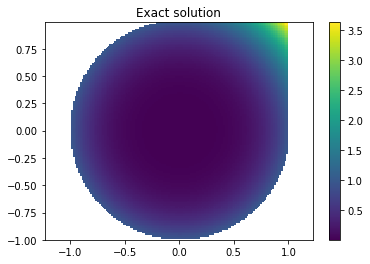

/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


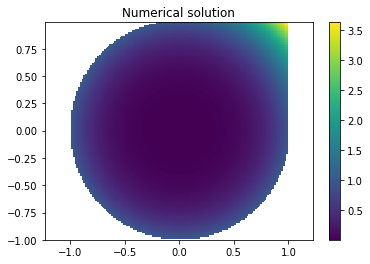

/Users/guillaume/.pyenv/versions/3.6.10/envs/notebooks/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


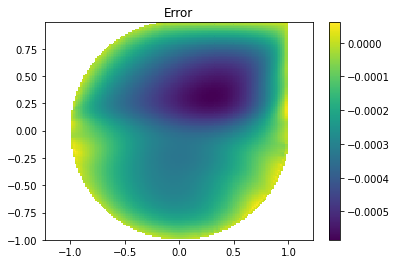

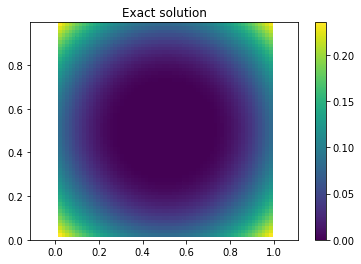

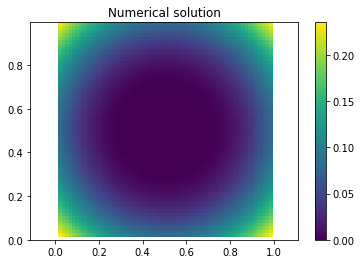

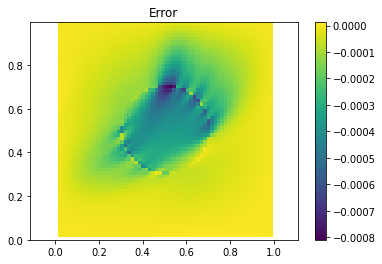

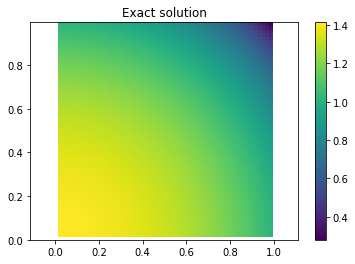

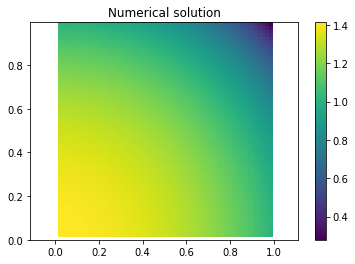

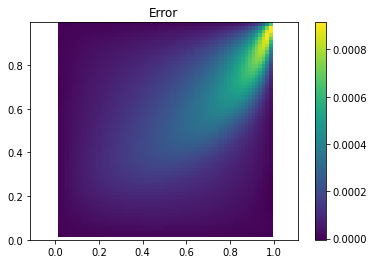

In [7]:
for u_func, domain, limits in [
    (u_smooth, domain_smooth, limits_smooth),
    (u_c1, domain_c1, limits_c1),
    (u_singular, domain_singular, limits_singular),
]:
    x = np.stack(
        np.meshgrid(
            np.arange(*limits[0], h_max), np.arange(*limits[1], h_max), indexing="ij"
        )
    )

    bc = Domain.Dirichlet(domain, u_func, x)

    u = u_func(x)
    f = EqLinear(u_func, x)

    u_approx = SolveLinear(x, f, bc)

    plt.title("Exact solution")
    plt.axis("equal")
    im = plt.pcolormesh(*x, np.where(bc.interior, u, np.nan))
    plt.colorbar(im)
    plt.show()

    plt.title("Numerical solution")
    plt.axis("equal")
    im = plt.pcolormesh(*x, np.where(bc.interior, u_approx, np.nan))
    plt.colorbar(im)
    plt.show()

    plt.title("Error")
    plt.axis("equal")
    im = plt.pcolormesh(*x, np.where(bc.interior, u - u_approx, np.nan))
    plt.colorbar(im)
    plt.show()

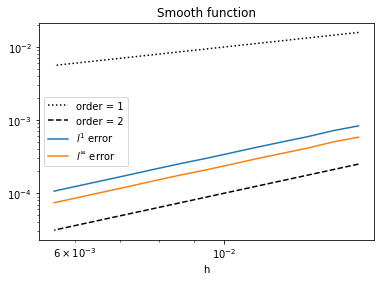

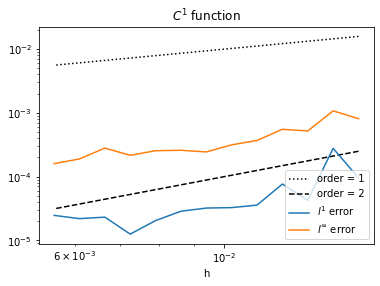

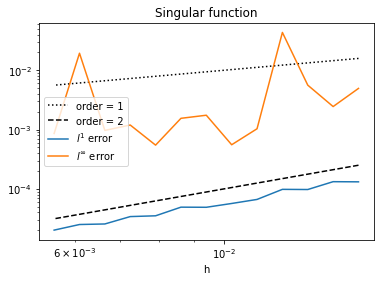

In [8]:

for u_func, domain, limits, title in [
    (u_smooth, domain_smooth, limits_smooth, "Smooth function"),
    (u_c1, domain_c1, limits_c1, "$C^1$ function"),
    (u_singular, domain_singular, limits_singular, "Singular function"),
]:
    h = h_max / 2 ** np.arange(0, 1.625, 0.125)
    err_l1 = np.zeros(h.shape)
    err_linf = np.zeros(h.shape)

    for i in range(len(h)):
        x = np.stack(
            np.meshgrid(
                np.arange(*limits[0], h[i]), np.arange(*limits[1], h[i]), indexing="ij"
            )
        )

        bc = Domain.Dirichlet(domain, u_func, x)

        u = u_func(x)
        f = EqLinear(u_func, x)

        u_approx = SolveLinear(x, f, bc)

        err_l1[i] = h[i] ** 2 * np.sum(np.abs(np.where(bc.interior, u - u_approx, 0)))
        err_linf[i] = np.max(np.abs(np.where(bc.interior, u - u_approx, 0)))

    plt.title(title)
    plt.xlabel("h")
    plt.loglog(h, h, "k:", label="order = 1")
    plt.loglog(h, h ** 2, "k--", label="order = 2")
    plt.loglog(h, err_l1, label="$l^1$ error")
    plt.loglog(h, err_linf, label="$l^\infty$ error")
    plt.legend()
    plt.show()